In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf
import time  # Import the time module
import os  # Import the os module
from sklearn.model_selection import TimeSeriesSplit

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

In [5]:
# reshape 2D dataset (samples + features) en 3D (samples/time step + features + séquence) 
# en ajoutant la dimension fenêtre/séquence (longueur est window_size) N, pour prédire N+1. 
# y_pos est la position de colonnes du target. Normalament la prémière colonne
# dataset.shape[0] est le nombre des échantillons
def rnn_3D_data(dataset, window_size, y_pos=0): 
    X = []
    y = []
    for i in range(window_size, dataset.shape[0]):
        X.append(dataset[i-window_size: i])
        y.append(dataset[i, y_pos])
    X, y = np.array(X), np.array(y)
    return X, y

In [6]:
def data_retrieve(stock, start_date, end_date): 

# Define the list of tickers for the stocks you want to fetch data for
    tickers = [stock]

    # Define the list of stock indices and other features
    indices = ['^GSPC', '^DJI', '^IXIC', 'DX-Y.NYB', '^GDAXI', '^FTSE', '^N225', '^VIX']
    commodities = ['GC=F', 'BZ=F']
    forex = ['EURUSD=X', 'JPY=X']

    symbols = indices + commodities + forex
    # Fetch the historical data using yfinance for tickers (OHLC and Volume)
    ticker_data = yf.download(tickers, start=start_date, end=end_date)

    # Fetch the historical data using yfinance for indices and commodities (Close Price)
    close_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Concatenate the close_data with the ticker_data to include Close Price for all symbols
    all_data = pd.concat([ticker_data, close_data], axis=1)

# Print the data
    return all_data

In [7]:
# Définir le modèle avec cycle scaling, reshing, compile, entrainement
def GRU_M0(df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout):

    scalar = MinMaxScaler()

    data_training_scaled = scalar.fit_transform(data_training)
    X_train, y_train = rnn_3D_data(data_training_scaled, window_size=win_size, y_pos=3)
    
    # add the winodw before test data
    data_test = pd.concat([data_training.tail(win_size), data_testing], ignore_index=True)
    data_test_scaled = scalar.fit_transform(data_test)
    X_test, y_test = rnn_3D_data(data_test_scaled, window_size=win_size, y_pos=3)
    
    y_scaler_train = MinMaxScaler()
    y_scaler_train.fit(data_training["Close"].values.reshape(-1, 1))
    y_scaler_test = MinMaxScaler()
    y_scaler_test.fit(data_test["Close"].values.reshape(-1, 1))
    
    model = Sequential()
    
    model.add(GRU(units = num_cell,  input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units = 1))

    start_time = time.time()
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    rnn_path = (results_path / 'gru_M0.h5').as_posix()
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
    
    lstm_training = model.fit(X_train, y_train, epochs=num_epoch, batch_size = batch_size,\
                        shuffle=True, validation_data=(X_test, y_test),\
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)     
    
    end_time = time.time()
    execution_time = end_time - start_time   
    
    # evaluer le modèle
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(lstm_training.history).pow(.5)
    loss_history.index += 1
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    
    resultat = ['GRU_M0',win_size,num_cell, num_epoch, batch_size, dropout, round(best_rmse, 4), round(execution_time, 0)]
    return model, resultat, lstm_training, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test

# Parameters

In [8]:
win_size = 60
num_epoch = 100
num_cell = 50
batch_size = 64
dropout = 0.5
split_date = '2020-12-31'
# pour stocker les modèles 
results_path = Path('models', 'GRU_M0')
if not results_path.exists():
    results_path.mkdir(parents=True)

# 1. Raw data collection

In [9]:
start_date = datetime.datetime(2010, 1, 2)
end_date = datetime.datetime.today()

In [10]:
raw_data = yf.download('^GSPC', start=start_date, end=end_date)
raw_data.to_parquet('sp500_data.parquet')

[*********************100%***********************]  1 of 1 completed


In [11]:
raw_data.to_parquet('sp500_data.parquet')

In [12]:
data = pd.read_parquet('sp500_data.parquet')

In [13]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [14]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3430 number of days in the dataset.


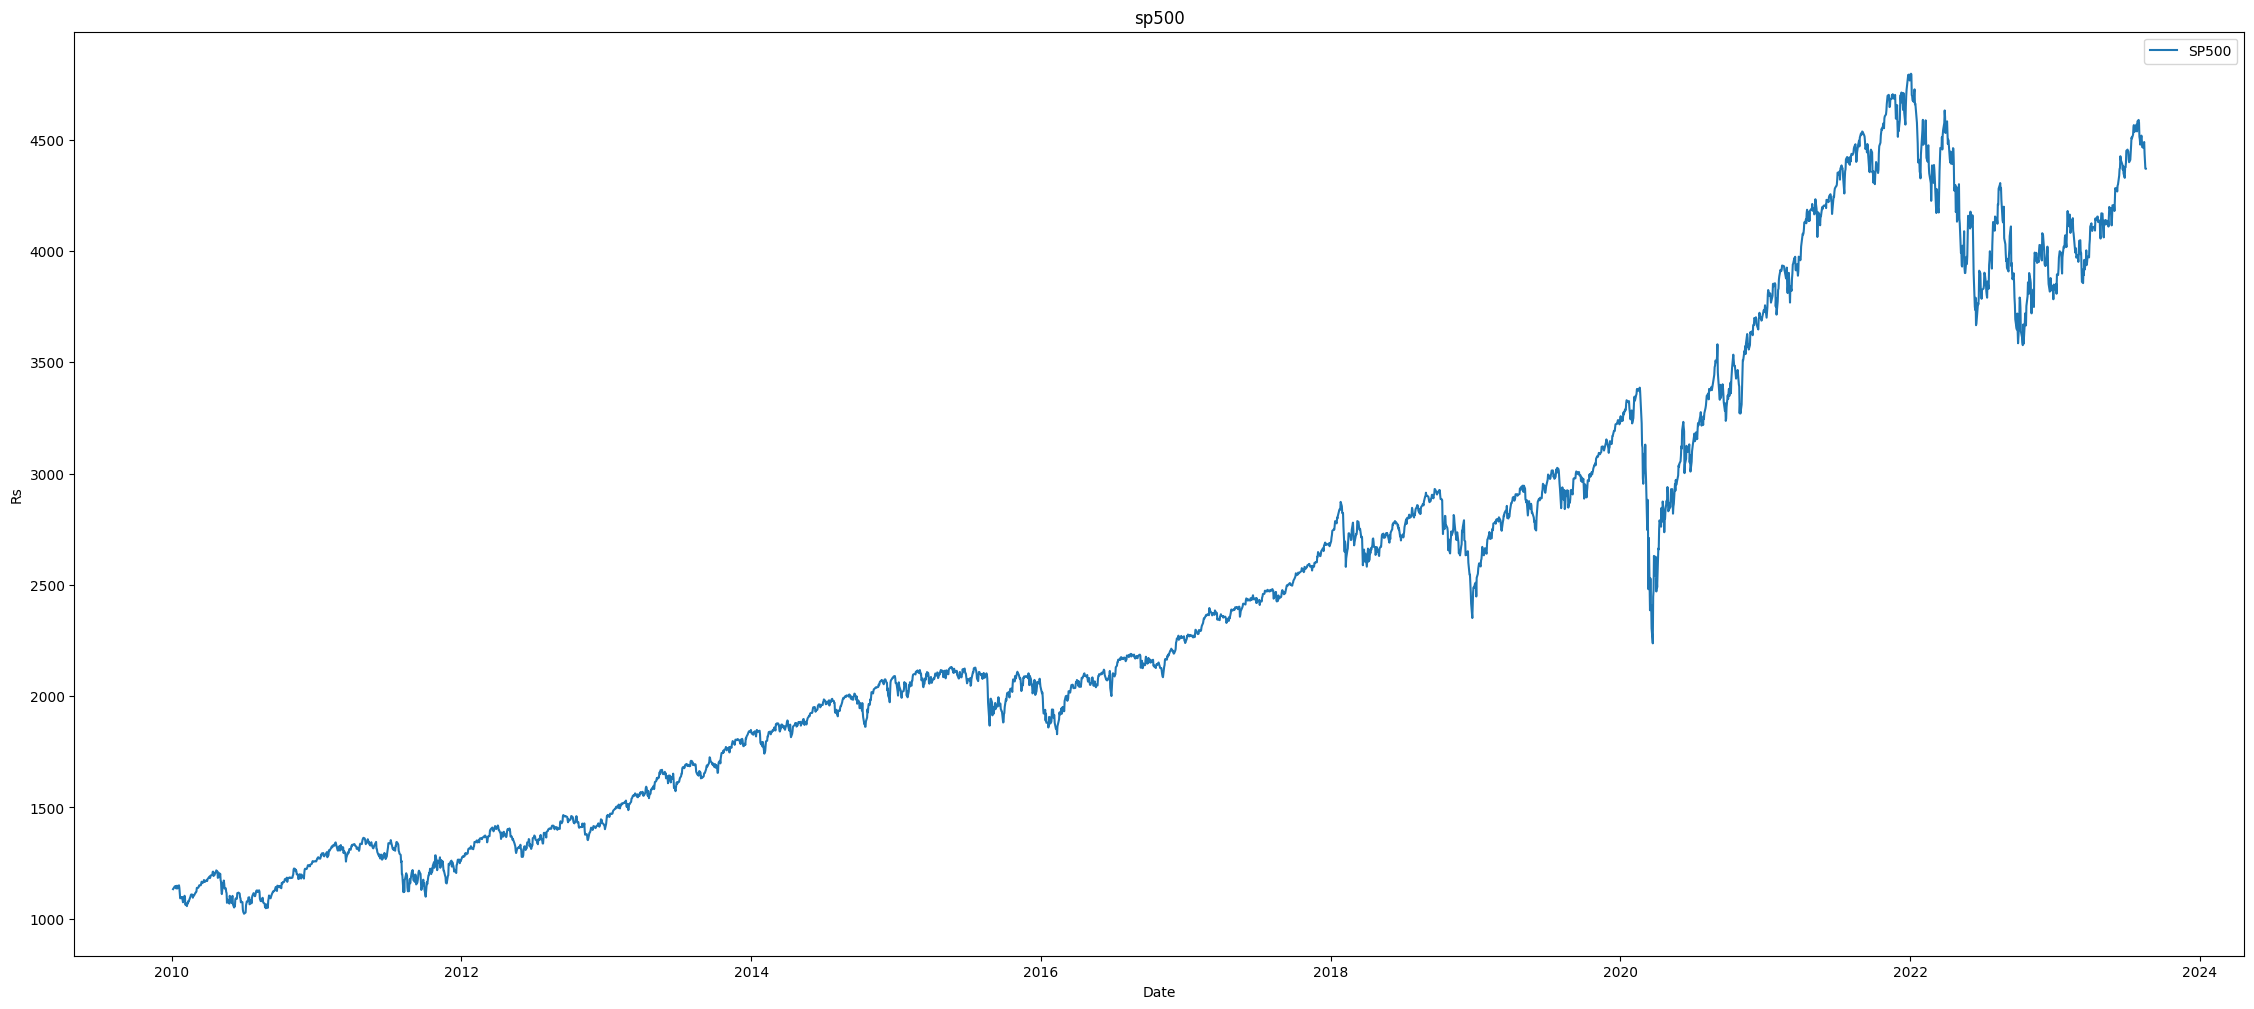

In [15]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Adj Close'], label='SP500')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('sp500')
plt.legend()
plt.show()

In [16]:
df = data.copy()
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [17]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3430 samples, and 6 features.


# 2. Feature engineering

In [18]:
FE_df = df

In [19]:
len(FE_df)

3430

# 3. Modèle processing

## 3.1. Data split

In [20]:
data_training = FE_df[FE_df.index < split_date].copy()
data_training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [21]:
y_train_real_all = data_training["Close"].values.reshape(-1, 1)

In [22]:
#remove the first win_size row which are without prediction
y_train_real = y_train_real_all[win_size:]

In [23]:
data_testing = FE_df[FE_df.index >= split_date].copy()
data_testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3179040000
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000


In [24]:
y_test_real = data_testing["Close"].values.reshape(-1, 1)

In [25]:
#scalar = MinMaxScaler()

#data_training_scaled = scalar.fit_transform(data_training)

## 3.2 Data scaling, reshaping, Model

In [26]:
current_datetime = datetime.datetime.today()
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M')

In [27]:
lstm_model, resultat, model_history, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test = \
GRU_M0(FE_df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.0447
Epoch 1: val_loss improved from inf to 0.00211, saving model to models/GRU_M0\gru_M0.h5
43/43 [==============================] - 4s 36ms/step - loss: 0.0447 - val_loss: 0.0021
Epoch 2/100
40/43 [==========================>...] - ETA: 0s - loss: 0.0143
Epoch 2: val_loss did not improve from 0.00211
43/43 [==============================] - 1s 25ms/step - loss: 0.0140 - val_loss: 0.0028
Epoch 3/100
41/43 [===========================>..] - ETA: 0s - loss: 0.0093
Epoch 3: val_loss improved from 0.00211 to 0.00178, saving model to models/GRU_M0\gru_M0.h5
43/43 [==============================] - 1s 21ms/step - loss: 0.0092 - val_loss: 0.0018
Epoch 4/100
42/43 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 4: val_loss did not improve from 0.00178
43/43 [==============================] - 1s 19ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 5/100
43/43 [==============================] - ETA: 0s - loss: 0

Epoch 38/100
43/43 [==============================] - ETA: 0s - loss: 0.0016
Epoch 38: val_loss did not improve from 0.00126
43/43 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 39/100
42/43 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 39: val_loss did not improve from 0.00126
43/43 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 40/100
40/43 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 40: val_loss improved from 0.00126 to 0.00124, saving model to models/GRU_M0\gru_M0.h5
43/43 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 41/100
42/43 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 41: val_loss did not improve from 0.00124
43/43 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 42/100
40/43 [==========================>...] - ETA: 0s - loss: 0.0016
Epoch 42: val_loss improve

Epoch 75/100
43/43 [==============================] - ETA: 0s - loss: 0.0015
Epoch 75: val_loss did not improve from 0.00115
43/43 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 76/100
43/43 [==============================] - ETA: 0s - loss: 0.0014
Epoch 76: val_loss improved from 0.00115 to 0.00112, saving model to models/GRU_M0\gru_M0.h5
43/43 [==============================] - 1s 22ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 77/100
43/43 [==============================] - ETA: 0s - loss: 0.0014
Epoch 77: val_loss did not improve from 0.00112
43/43 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 78/100
43/43 [==============================] - ETA: 0s - loss: 0.0014
Epoch 78: val_loss did not improve from 0.00112
43/43 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 79/100
41/43 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 79: val_loss improve

In [28]:
resultat.insert(0, formatted_datetime)

# 4. Evaluation performance

## 4.1. Scaled performance

In [29]:
def lstm_scaled_perfomance(model_history, start_epoch=1):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(start_epoch, start_epoch + len(model_history.history['loss']))
    
    # loss, val_loss 
    axs[0].plot(epochs, model_history.history['loss'], label='Training Loss')
    axs[0].plot(epochs, model_history.history['val_loss'],  label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validation'], loc='best')
    
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(model_history.history).pow(.5)
    loss_history.index += 1    
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    best_epoch = loss_history.val_loss.idxmin()    
    title = f'Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
    loss_history.columns=['Training RMSE', 'Validation RMSE']
    
    loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=axs[1])    
    axs[1].axvline(best_epoch, ls='--', lw=1, c='k')
    
    sns.despine()
    fig.tight_layout()    
    plt.show()
    return best_rmse, best_epoch

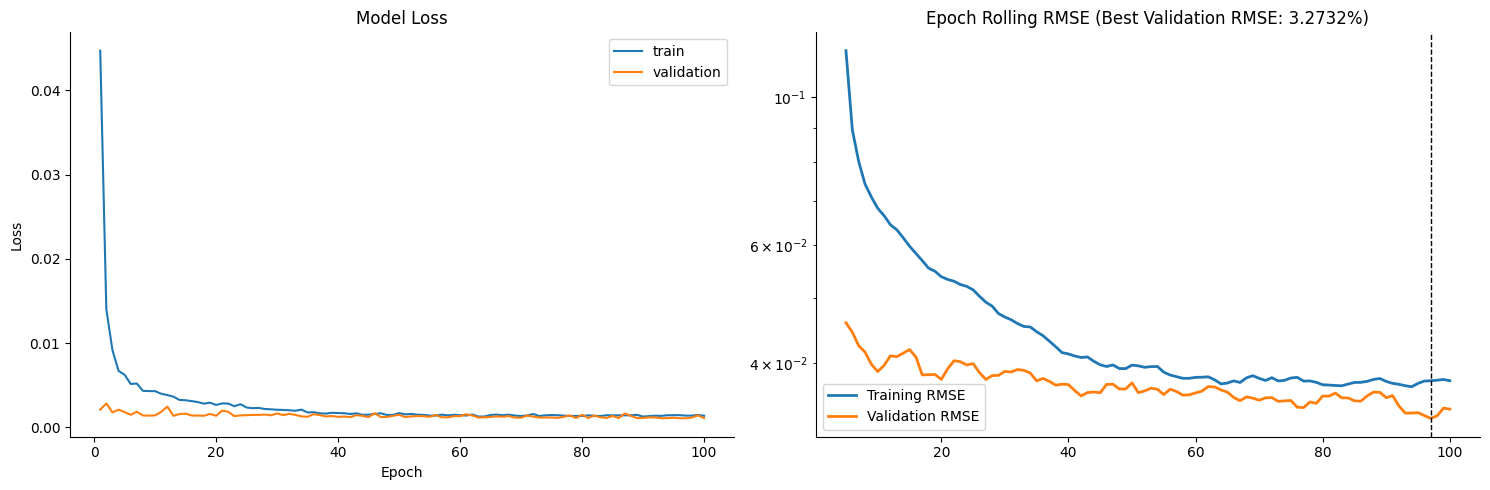

In [30]:
best_rmse, best_epoch = lstm_scaled_perfomance(model_history)

In [31]:
y_train_predict_scaled = lstm_model.predict(X_train)
y_test_predict_scaled = lstm_model.predict(X_test)

21/21 [==============================] - 0s 5ms/step


In [32]:
from scipy.stats import spearmanr
train_ic = spearmanr(y_train, y_train_predict_scaled)[0]
test_ic = spearmanr(y_test, y_test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9990 | Test IC: 0.9830


In [33]:
resultat.extend([round(train_ic, 4), round(test_ic,4)])

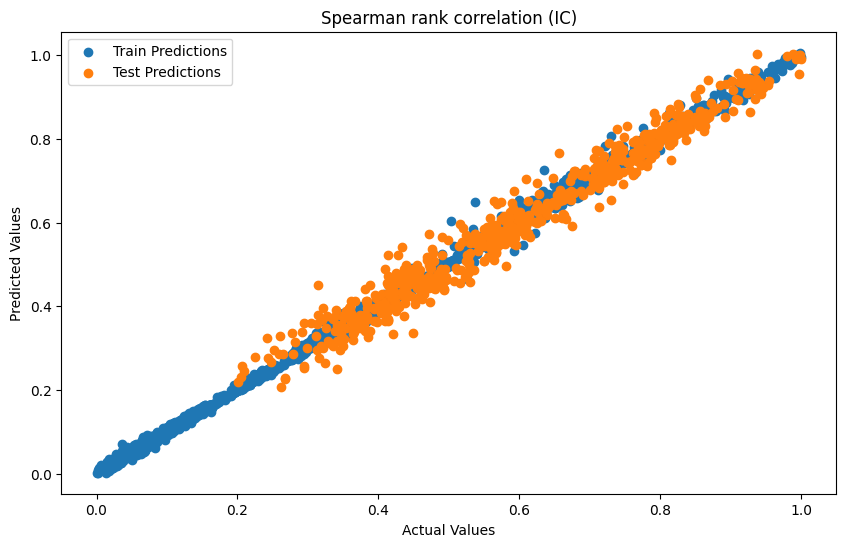

In [34]:
import matplotlib.pyplot as plt

# Plotting the train and test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_predict_scaled, label='Train Predictions')
plt.scatter(y_test, y_test_predict_scaled, label='Test Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Spearman rank correlation (IC)')
plt.legend()
plt.show()

## 4.2. Rescaled performance

In [35]:
def lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(y_train_real, color = 'red', label = 'Real SP500 Price')
    axs[0].plot(y_train_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[0].set_title('SP500 Train Price Prediction')
    axs[0].set_ylabel('Price')
    axs[0].set_xlabel('Time')
    axs[0].legend(['Real', 'Predict'], loc='best')

    axs[1].plot(y_test_real, color = 'red', label = 'Real SP500 Price')
    axs[1].plot(y_test_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[1].set_title('SP500 Test Price Prediction')
    axs[1].set_ylabel('Price')
    axs[1].set_xlabel('Time')
    axs[1].legend(['Real', 'Predict'], loc='best')

    plt.legend()  
    plt.show()
    return

In [36]:
y_test_predict = y_scaler_test.inverse_transform(y_test_predict_scaled)
y_train_predict = y_scaler_train.inverse_transform(y_train_predict_scaled)

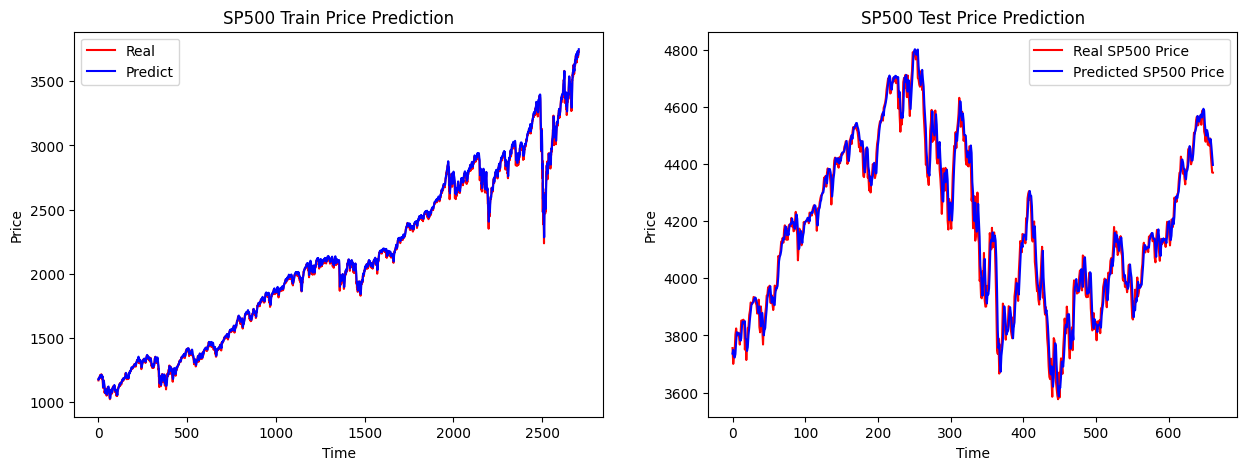

In [37]:
lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict)

In [38]:
train_rmse_scaled = np.sqrt(lstm_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0098 | Test RMSE: 0.0332


In [39]:
resultat.extend([round(train_rmse_scaled, 4), round(test_rmse_scaled,4)])

In [40]:
train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train_real))
test_rmse = np.sqrt(mean_squared_error(y_test_predict, y_test_real))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 26.64 | Test RMSE: 50.63'

In [41]:
resultat.extend([round(train_rmse, 2), round(test_rmse,2)])

In [42]:
models_performance = pd.read_csv('models_performance.csv', index_col=[0])
models_performance.loc[len(models_performance)] = resultat
models_performance.to_csv('models_performance.csv')

In [43]:
def real_predict_dist(y_train_real, y_train_predict, y_test_real, y_test_predict):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    diff_train = y_train_predict - y_train_real
    diff_test = y_test_predict - y_test_real
    
# Création de l'histogramme de la distribution
    axs[0].hist(diff_train, bins=20, edgecolor='black')
# Ajout de labels et de titres
    axs[0].set_xlabel('Différence entre y_train_predict et y_train_real')
    axs[0].set_ylabel('Fréquence')
    axs[0].set_title('Distribution différence train')

    # Création de l'histogramme de la distribution
    axs[1].hist(diff_test, bins=20, edgecolor='black')
# Ajout de labels et de titres
    axs[1].set_xlabel('Différence entre y_test_predict et y_test_real')
    axs[1].set_ylabel('Fréquence')
    axs[1].set_title('Distribution différence test')

    plt.show()
    return

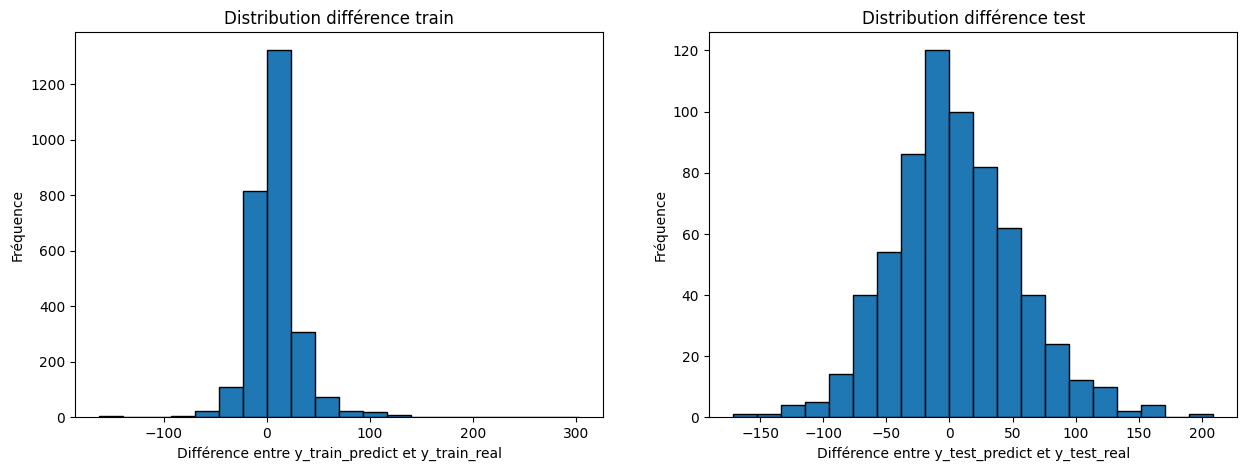

In [44]:
real_predict_dist(y_train_real, y_train_predict, y_test_real, y_test_predict)